## Physical Review B , 106, 035432 (2022)
Reproducing results presented in https://journals.aps.org/prb/pdf/10.1103/PhysRevB.106.035432

In [ ]:
%load_ext autoreload

import kwant
import numpy as np
import matplotlib.pyplot as plt 
import kwant.continuum
import scipy.sparse.linalg as sla
import tinyarray as tiny
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

%matplotlib widget
mpl.rcParams.update({'font.size': 20, 'text.usetex': True,  'font.family': 'serif', 'font.serif': ['Computer Modern']})

sx = tiny.array([[0 , 1] , [1 , 0]])
sy = tiny.array([[0 , -1j] , [1j , 0]])
sz = tiny.array([[1 , 0] , [0 , -1]])


I = tiny.array([[1 , 0] , [0 , 1]])
t_plus = 0.5*(np.kron(sx , I) + 1j*np.kron(sy , I))
t_minus = t_plus.T
phs = np.kron(sy , sy)

In [211]:
from dataclasses import dataclass
@dataclass
class system_parameters:
    t : float # Hopping integral
    W: float # Width of normal region
    L: float # Length of normal region
    a : float # Lattice constant
    mu : float # Chemical potential
    Delta: float # SUperconducting gap.
    flux: float # Flux throught the normal region.
    phase: float  # Josephson phase difference. 

params = system_parameters(t =1 , W = 20 , L = 5 , a = 0.5 , Delta = 5 , mu = 0.8, flux= 0 , phase = 0.0)

# In my units e = h = 1. So Phi_0 , the elementary flux quantum is 1 and the superconducting flux quantum is 1/2.
# Function for computing normal S-matrix. 
def compute_normal_s_matrix(params):
    B = params.flux/((params.W -1 )*(params.L - 1))
    peierlphase = B*params.a*np.pi
    syst = kwant.Builder()
    lat = kwant.lattice.square(a = params.a)
    for i in range(int(params.W / params.a)):
        for j in range(int(params.L / params.a)):
            syst[lat(i , j)] = 4*params.t/(params.a**2) - params.mu
            if i > 0:
                syst[lat(i , j) , lat(i-1 , j)] = -params.t/(params.a**2)
            if j > 0:
                syst[lat(i , j) , lat(i , j-1)] = -params.t*np.exp(1j*i*peierlphase)/(params.a**2)
    
    # Construct normal leads, with no magnetic field to account for screening.
    lead = kwant.Builder(kwant.TranslationalSymmetry((0 , -params.a)))
    for i in range(int(params.W / params.a)):
        lead[lat(i , 0)] = 4*params.t - params.mu
        if i > 0:
            lead[lat(i , 0) , lat(i-1 , 0)] = -params.t
        lead[lat(i , 1) , lat(i , 0)] = -params.t
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())
    syst = syst.finalized()
    # Compute S-matrix of the normal region between leads. In the short junction regime , we can calcualte it at E = 0.
    s_matrix = kwant.smatrix(syst , 0)
    return s_matrix

In [212]:
s_matrix_test  = compute_normal_s_matrix(params)
lead_info = s_matrix_test.lead_info
num_propagating = s_matrix_test.num_propagating(0)
print(num_propagating)
len(lead_info[0].momenta)

12


24

In [213]:
# Andreev reflection matrix:
def andreev(smatrix , params):
    # We need to know how many modes are in each lead:
    N = smatrix.num_propagating(0)
    M = smatrix.num_propagating(1)

    r_A00 = 1j*np.identity(N)
    r_A11 = 1j*np.exp(-1j*params.phase)*np.identity(M)
    r_A01 = np.zeros(shape = (N , M))
    r_A10 = np.zeros(shape = (M , N))
    r_A = np.block([[r_A00 , r_A01],[r_A10 , r_A11]])
    r_A_deriv = np.block([[np.zeros(shape = (N , N)) , r_A01],[r_A10 , -1j*r_A11]])
    return  r_A , r_A_deriv

# Compute Andreev bound states:
def compute_ABS(smatrix , params):
    r_A = andreev(smatrix , params)[0]
    s = smatrix.data
    #  Calculate A matrix:
    A = (-s.T @ r_A + r_A @ s)/2
    
    # Constructing matrix to diagonalise for energies:
    zeroes = np.zeros(shape = A.shape)
    matrix = np.block([[zeroes , -1j*np.conjugate(A.T)],[1j*A , zeroes]])
    evals , evecs = np.linalg.eigh(params.Delta*matrix)
    return evals , evecs

In [214]:
evals , evecs = compute_ABS(s_matrix_test , params)

[-2.21395661e-12 -2.21395661e-12 -2.19183700e-12 -2.19183700e-12
 -9.18495734e-13 -9.18495734e-13 -9.16790029e-13 -9.16790029e-13
 -4.77780242e-13 -4.77780242e-13 -3.82727836e-13 -3.82727836e-13
 -2.28729894e-13 -2.28729894e-13 -2.26865423e-13 -2.26865423e-13
 -1.47275376e-13 -1.47275376e-13 -1.43622353e-13 -1.43622353e-13
 -4.91969901e-14 -4.91969901e-14 -1.95321823e-14 -1.95321823e-14
  1.95321823e-14  1.95321823e-14  4.91969901e-14  4.91969901e-14
  1.43622353e-13  1.43622353e-13  1.47275376e-13  1.47275376e-13
  2.26865423e-13  2.26865423e-13  2.28729894e-13  2.28729894e-13
  3.82727836e-13  3.82727836e-13  4.77780242e-13  4.77780242e-13
  9.16790029e-13  9.16790029e-13  9.18495734e-13  9.18495734e-13
  2.19183700e-12  2.19183700e-12  2.21395661e-12  2.21395661e-12]


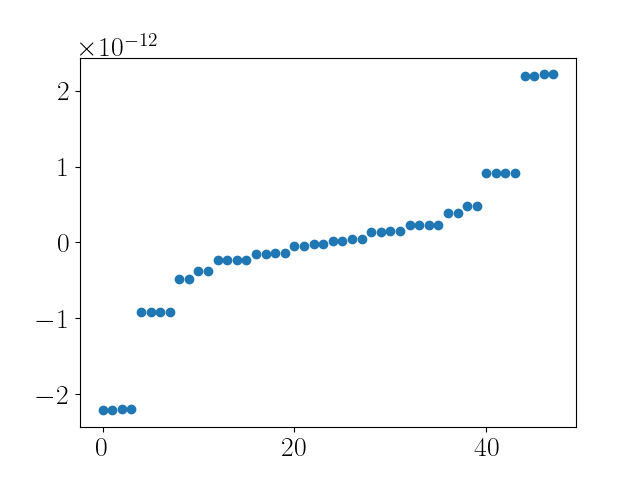

In [215]:
print(evals )
plt.figure()
plt.scatter(np.arange(len(evals)) , evals)

In [216]:
# Compute critical currents:
def compute_I_c(flux_value , params):
    # Values for superconducting phase
    phases = np.linspace(0 , 2*np.pi , 100)
    params.flux = flux_value
    pos_evals = []
    for phase in phases:
        params.phase = phase
        smatrix = compute_normal_s_matrix(params)
        evals , evecs = compute_ABS(smatrix , params)
        # Extract positive evals:
        pos_evals.append(evals[evals > 0])
    pos_evals = np.stack(pos_evals , axis = 1)
    # Sum up all the positive eigenenergies for each pahse value:
    summed = np.sum(pos_evals , axis = 0)
    # Current is gradient of all of the positive eigeneneries:
    current = np.gradient(summed)
    I_c = np.max(current)
    return I_c , current

In [217]:
from tqdm import tqdm
fluxes = np.linspace(0 , 5 , 101)
I_c_values = np.zeros(len(fluxes))
currents = []
for i in tqdm(range(len(fluxes))):
    I_c_values[i] , blah = compute_I_c(fluxes[i] , params)
    currents.append(blah)
currents = np.stack(currents , axis = 1)

100%|██████████| 101/101 [11:03<00:00,  6.57s/it]


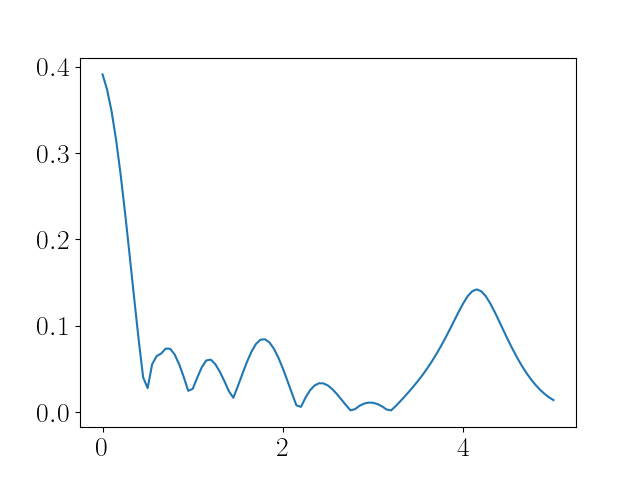

In [218]:
plt.figure()
plt.plot(fluxes , I_c_values)

In [ ]:
test_list= [np.array([1 , 0]) , np.array([2 , 3])]
stacked = np.stack(test_list  , axis= 1)
stacked
